# gem5 DRAM Caching Plots

In [111]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [112]:
datadir = '/data/DRAMCaching-Controller/Results/'

In [113]:
def getStat(filename, stat):
    #filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    #print(stat)
    #print(filename)
    try:
        with open(filename) as f:
            readlines = f.readlines()
            for l in readlines:
                if stat in l:
                    return l
            return 0.0 #for cases where stat was not found
    except: #for cases where the file was not found
        return 0.0

In [114]:
Stats = ['system.processor.cores.generator.bytesWritten', 'system.processor.cores.generator.avgWriteLatency', 
         'system.processor.cores.generator.writeBW', 'system.processor.cores.generator.avgReadLatency', 
         'system.processor.cores.generator.readBW', 'system.processor.cores.generator.numPackets', 
         'system.processor.cores.generator.numRetries']

modes = ['gem5', 'gem5_dcache', 'gem5_dcache_old', 'gem5_dcache_all_memory']
devices = ['ddr3', 'ddr4', 'hbm']
inj_rate = ['20', '40', '60']
pattern = ['linear', 'random']
rd_prct = ['100', '70', '0']
duration = ['10ms']

In [115]:
#if pdf v1.5 is not used the hatches in generated figs do not show up on certain pdf viewers
# this function takes care of that issue
def savepdfviasvg(fig, name, **kwargs):
    import subprocess
    fig.savefig(name+".svg", format="svg", **kwargs)
    incmd = ["inkscape", name+".svg", "--export-pdf={}.pdf".format(name),
             "--export-pdf-version=1.5"] #"--export-ignore-filters",
    subprocess.check_output(incmd)

In [116]:
rows = []

for pat in pattern:
    for inj in inj_rate:
        for dev in devices:
            for rds in rd_prct:
                for dur in duration:
                    for mod in modes:
                        stats = [pat, inj, dev, rds, dur, mod]
                        for stat in Stats:
                            time_file_path = '{}/results_{}/{}_{}_{}_{}_{}/stats.txt'.format(datadir, mod, pat, dur, dev, inj, rds)
                            ret_line = getStat(time_file_path,stat)
                        
                            if ret_line != 0:
                                stat_val = ret_line.split()[1]
                            else:
                                stat_val = 1
                            stats.append(stat_val)
        
                        rows.append(stats) 


df = pd.DataFrame(rows, columns=['pattern','inj_rate','device','rd_perct','duration','mode',
                                 'bytesWritten', 'avgWriteLatency', 'writeBW', 'avgReadLatency',
                                 'readBW', 'numPackets', 'numRetries'])

In [117]:
df['totBW'] = df['readBW'].astype(float) + df['writeBW'].astype(float)

In [118]:
print(df[(df['pattern']=='linear') & (df['device']=='ddr4')])

   pattern inj_rate device rd_perct duration                    mode  \
12  linear       20   ddr4      100     10ms                    gem5   
13  linear       20   ddr4      100     10ms             gem5_dcache   
14  linear       20   ddr4      100     10ms         gem5_dcache_old   
15  linear       20   ddr4      100     10ms  gem5_dcache_all_memory   
16  linear       20   ddr4       70     10ms                    gem5   
17  linear       20   ddr4       70     10ms             gem5_dcache   
18  linear       20   ddr4       70     10ms         gem5_dcache_old   
19  linear       20   ddr4       70     10ms  gem5_dcache_all_memory   
20  linear       20   ddr4        0     10ms                    gem5   
21  linear       20   ddr4        0     10ms             gem5_dcache   
22  linear       20   ddr4        0     10ms         gem5_dcache_old   
23  linear       20   ddr4        0     10ms  gem5_dcache_all_memory   
48  linear       40   ddr4      100     10ms                    

In [135]:
def doplot_stat(pat, inj, duration, device, stat):   
    i = 0
    
    for r, rdp in enumerate(rd_prct):
        
        for m, mod in enumerate(modes):
            
            d = df[(df['pattern']==pat) & (df['inj_rate']==inj) & (df['duration']==duration) & 
                  (df['device']==device) & (df['mode']==mod) & (df['rd_perct']==rdp)]
            
            
            if stat == 'readBW' or stat == 'writeBW' or stat == 'totBW':
                #print(float(d[stat].iloc[0]))
                plt.bar(i, float(d[stat].iloc[0])/(1024*1024*1024), color='C'+str(m))    
            else:
                plt.bar(i, float(d[stat].iloc[0]), color='C'+str(j))
            
            i = i+1

        i = i+1
                    
    for i,pfrm in enumerate(['gem5', 'gem5_unified', 'gem5_multiq', 'gem5_multiq_miss']):
        plt.bar(0,0,color='C'+str(i), label=pfrm)
    plt.xticks([0,1,2,3,5,6,7,8,10,11,12,13], ['gem5','gem5_uni','gem5_mq','gem5_mqmiss','gem5','gem5_uni', 
                                               'gem5_mq','gem5_mqmiss','gem5', 'gem5_uni','gem5_mq',
                                               'gem5_mqmiss'], rotation=90, ha='center',fontsize=8)

<IPython.core.display.Javascript object>


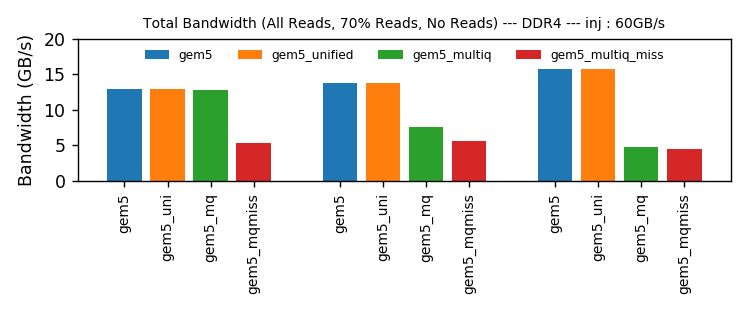

In [136]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('linear', '60', '10ms', 'ddr4', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=20)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


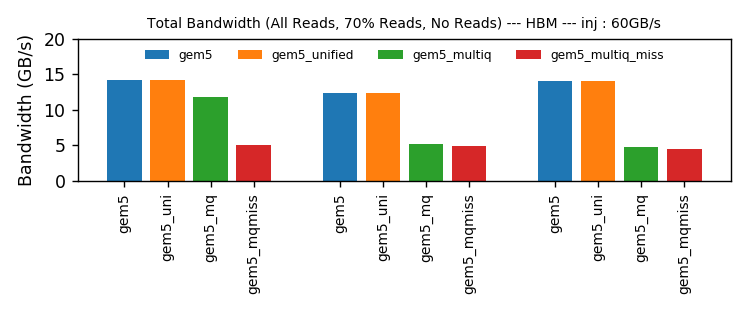

In [137]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('linear', '60', '10ms', 'hbm', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=20)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- HBM --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


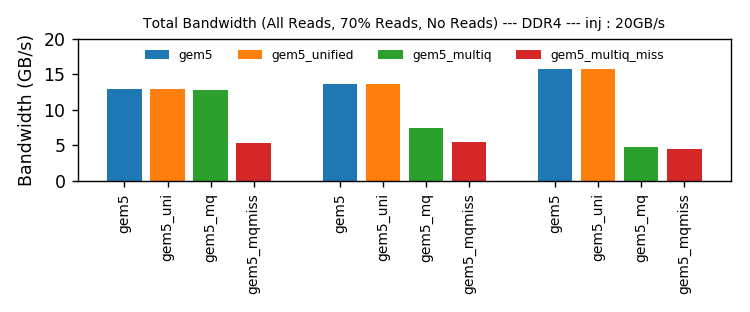

In [138]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('linear', '20', '10ms', 'ddr4', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=20)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 20GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


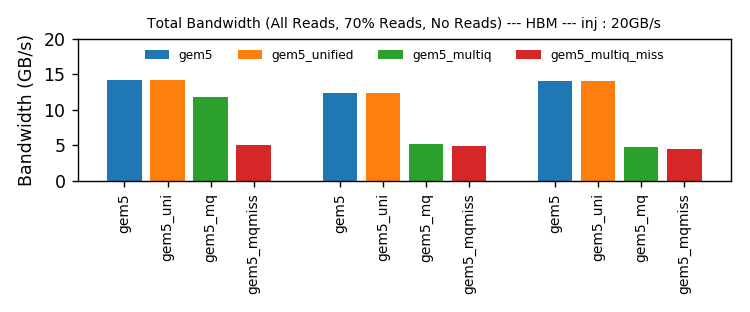

In [139]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('linear', '20', '10ms', 'hbm', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=20)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- HBM --- inj : 20GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


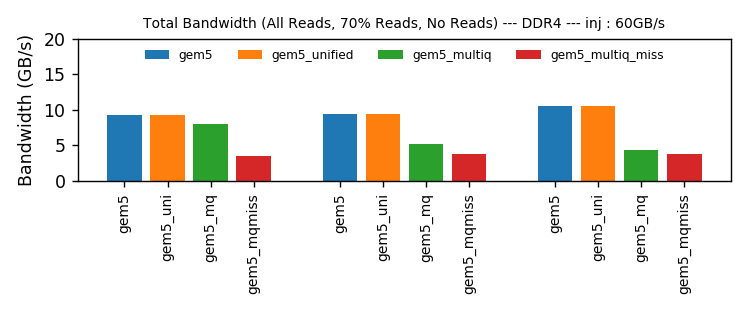

In [140]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('linear', '60', '10ms', 'ddr3', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=20)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")

<IPython.core.display.Javascript object>


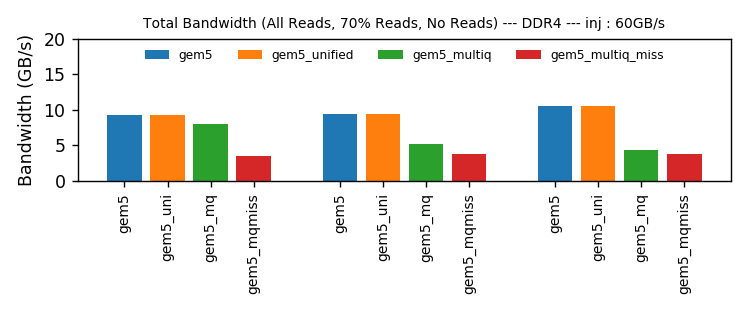

In [141]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 2.5

plt.figure()

doplot_stat('linear', '20', '10ms', 'ddr3', 'totBW')

plt.ylabel('Bandwidth (GB/s)')
plt.ylim(ymax=20)
#plt.text(18.4, 100, '220', fontsize=7, color='C'+str(1), bbox=dict(boxstyle="square", 
#                   ec=(1., 0.5, 0.5),
#                   fc=(1., 0.8, 0.8),
#                   ))
plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
plt.title('Total Bandwidth (All Reads, 70% Reads, No Reads) --- DDR4 --- inj : 60GB/s', fontsize=8)
#plt.yscale("log")
plt.tight_layout()
#plt.savefig('sev_perf_npb_c', format='pdf', dpi=1000)
#savepdfviasvg(plt, "sev_perf_default_npb_c")